In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

# tf.enable_v2_behavior()

In [2]:
from read_co2 import read_co2

x,y = read_co2('co2_mm_mlo.txt') # Getting the data

y_valid = y >= 0.
y = y[y_valid]
x = x[y_valid]

forecast_years = 10*12
y_trun = y[:-forecast_years] # Truncating data  to use for training
x_trun = x[:-forecast_years]

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


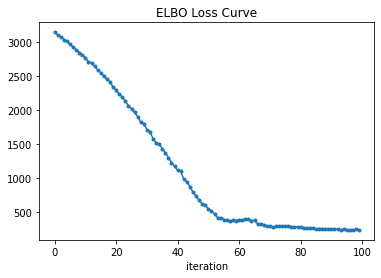

In [3]:
# Getting the local linear trend and seasonal effects
trend = tfp.sts.LocalLinearTrend(observed_time_series=y_trun)
seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=y_trun)
model = tfp.sts.Sum([trend, seasonal], observed_time_series=y_trun)

# Initializing the posterior
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

# Amount of steps to train the 
num_variational_steps = 100

# Set optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Defining the training for the model
def train():
    # Build the joint density. 
    target_log_prob_fn = model.joint_log_prob(
        observed_time_series=y_trun
    )
    
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
    )
    
    return elbo_loss_curve

# Run optimization.
elbo_loss_curve = train()

# Plot the Elbo Loss Curve to Show Number of Steps is Sufficient
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve, marker='.')
ax.set(title='ELBO Loss Curve', xlabel='iteration');

# Draw samples from the variational posterior
q_samples_co2_ = variational_posteriors.sample(50)

Here, we can choose to have less iterations for similar losses, as returns rapidly diminish beyond 50 steps.

In [4]:
# Now we make the prediction
co2_forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=y_trun,
    parameter_samples=q_samples_co2_,
    num_steps_forecast=forecast_years)

In [5]:
# Here we create 10 sample distributions and get the mean curve with its standard of deviation
num_samples=10

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean().numpy()[..., 0],
    co2_forecast_dist.stddev().numpy()[..., 0],
    co2_forecast_dist.sample(num_samples).numpy()[..., 0])

<Figure size 432x288 with 0 Axes>

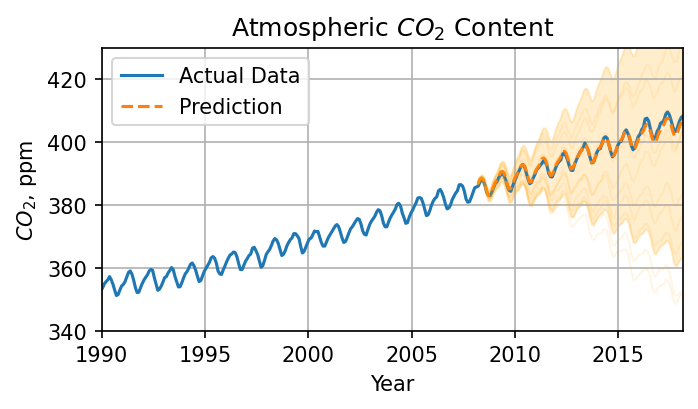

In [6]:
# Plotting everything
f2 = plt.figure(2)
plt.figure(figsize=(5, 2.5), dpi=150)

# Plot the real data
plt.plot( x, y ,label='Actual Data')

# Plot the average prediction
plt.plot(x[-forecast_years:],co2_forecast_mean,ls='--',label='Prediction')

# Plot the Sample curves in the predictions
plt.plot(x[-forecast_years:], co2_forecast_samples.T, lw=1, color='orange', alpha=0.1)

# Plot the range of Curves predicted
plt.fill_between(x[-forecast_years:],
                   co2_forecast_mean-2*co2_forecast_scale,
                   co2_forecast_mean+2*co2_forecast_scale, color='orange', alpha=0.2)

plt.title(r'Atmospheric $CO_2$ Content')
plt.ylabel(r'$CO_2$, ppm')
plt.xlabel('Year')
plt.axis([1990,x[-1],340,430])
plt.grid(1)
plt.legend()

plt.show()

Here using the model from Tensorflow, we see that the mean prediction is nearly spoton, but is slightly lower than expected. This makes sense as visually the $CO_2$ concentration's growth seems to be a tad higher order than linear (which is not good for us). The orange does show the range of the prediction in it's confidence interval which clearly encompases the true data. The prediction is quite accurate and could theoretically be used for the future, provided no drastic changes to the environment occur.